In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Style Einstellungen für schönere Plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Pfad zum Output-Ordner
output_dir = os.path.join('Data', 'output')

# Suche alle CSV Dateien
list_of_files = glob.glob(os.path.join(output_dir, '*.csv'))

if not list_of_files:
    print("❌ Keine Ergebnis-Dateien gefunden! Bitte führe erst main.py aus.")
else:
    # Die neueste Datei finden (basierend auf Erstellungsdatum)
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"📂 Lade Datei: {latest_file}")

    df = pd.read_csv(latest_file)

    # Aufteilen in Rank 1 (Gewinner) und Rank 2 (Zweiter)
    rank1 = df[df['rank'] == 1].copy()
    rank2 = df[df['rank'] == 2].copy()

    print(f"✅ Daten geladen.")
    print(f"   Anzahl Transienten: {df['SN_ID'].nunique()}")
    print(f"   Anzahl Kandidaten gesamt: {len(df)}")

    # Zeige die ersten Zeilen der Gewinner
    display(rank1.head())

📂 Lade Datei: Data/output/CF_limit_hosts_combined_dr4_SCORED.csv
✅ Daten geladen.
   Anzahl Transienten: 73966
   Anzahl Kandidaten gesamt: 1145237


,SN_ID,Host_RA,Host_DEC,d_DLR,mag_r,mag_g,mag_i,mag_z,z_phot_mean_i,normalized_prob,rank
0,ZTF18aaaayfq,113.387487,19.293254,12.543270,23.690297,24.156478,NaN,22.766813,-99.0,0.859505,1.0
11,ZTF18aaabsao,123.364445,54.369201,131.281026,22.333445,23.082662,NaN,21.213958,NaN,0.960231,1.0
23,ZTF18aaacesi,127.503891,54.747603,71.660656,24.972894,24.804184,NaN,22.968363,NaN,0.969823,1.0
39,ZTF18aaahyvk,126.174866,54.226075,6.046696,20.415704,20.666190,NaN,22.174774,NaN,0.953148,1.0
69,ZTF18aaaiuua,131.004653,56.936618,0.310748,16.784014,17.791293,NaN,16.024623,NaN,0.828675,1.0


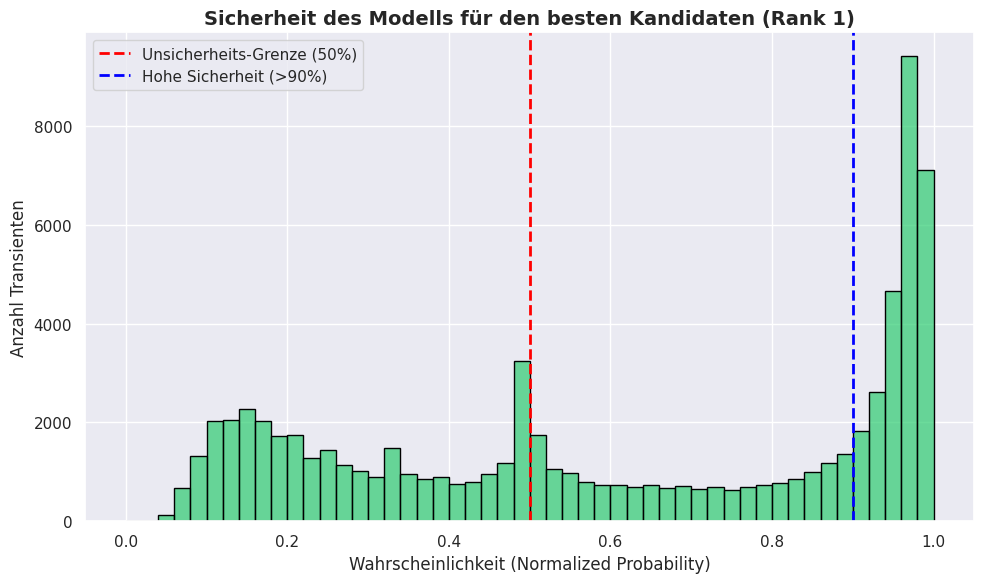

📊 Statistik:
   Durchschnittliche Wahrscheinlichkeit: 61.09%
   Anteil mit > 90% Sicherheit: 34.67%


In [12]:
plt.figure(figsize=(10, 6))

# Histogramm der Wahrscheinlichkeit für Rank 1
sns.histplot(rank1['normalized_prob'], bins=np.linspace(0, 1, 51), kde=False, color='#2ecc71', edgecolor='black', alpha=0.7)

plt.title('Sicherheit des Modells für den besten Kandidaten (Rank 1)', fontsize=14, fontweight='bold')
plt.xlabel('Wahrscheinlichkeit (Normalized Probability)', fontsize=12)
plt.ylabel('Anzahl Transienten', fontsize=12)

# Linien für 50% und 90%
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Unsicherheits-Grenze (50%)')
plt.axvline(0.9, color='blue', linestyle='--', linewidth=2, label='Hohe Sicherheit (>90%)')

plt.legend()
plt.tight_layout()
plt.show()

# Kurze Statistik
high_conf = (rank1['normalized_prob'] >= 0.9).mean()
print(f"📊 Statistik:")
print(f"   Durchschnittliche Wahrscheinlichkeit: {rank1['normalized_prob'].mean():.2%}")
print(f"   Anteil mit > 90% Sicherheit: {high_conf:.2%}")

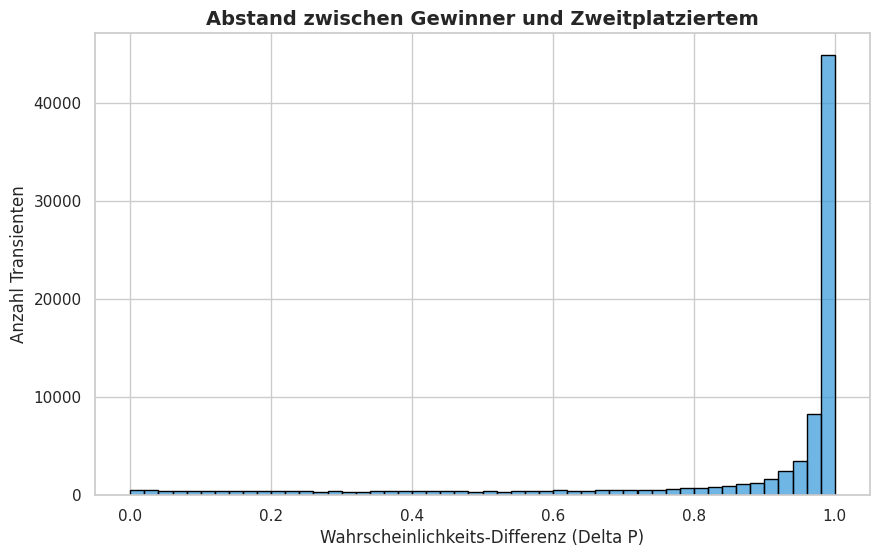

🔥 Enge Entscheidungen (Differenz < 0.2): 4479 Transienten


In [8]:
# Daten zusammenfügen (Rank 1 und Rank 2 nebeneinander)
merged = pd.merge(rank1[['SN_ID', 'normalized_prob']],
                  rank2[['SN_ID', 'normalized_prob']],
                  on='SN_ID', how='left', suffixes=('_r1', '_r2'))

# Falls es keinen Rank 2 gibt (nur 1 Kandidat vorhanden), setzen wir prob auf 0
merged['normalized_prob_r2'] = merged['normalized_prob_r2'].fillna(0)

# Differenz berechnen
merged['diff'] = merged['normalized_prob_r1'] - merged['normalized_prob_r2']

plt.figure(figsize=(10, 6))
sns.histplot(merged['diff'], bins=np.linspace(0, 1, 51), kde=False, color='#3498db', edgecolor='black', alpha=0.7)

plt.title('Abstand zwischen Gewinner und Zweitplatziertem', fontsize=14, fontweight='bold')
plt.xlabel('Wahrscheinlichkeits-Differenz (Delta P)', fontsize=12)
plt.ylabel('Anzahl Transienten', fontsize=12)

plt.show()

# Stats
close_calls = (merged['diff'] < 0.2).sum()
print(f"🔥 Enge Entscheidungen (Differenz < 0.2): {close_calls} Transienten")

In [9]:
# Wir filtern nur Rank 1 Kandidaten, die einen Redshift haben
if 'z_phot' in rank1.columns and rank1['z_phot'].notna().sum() > 0:
    df_z = rank1[rank1['z_phot'].notna()].copy()

    # Trennen nach Sicherheit
    # Sicher: >= 50% (Blau)
    # Unsicher: < 50% (Rot)
    z_high = df_z[df_z['normalized_prob'] >= 0.5]['z_phot']
    z_low = df_z[df_z['normalized_prob'] < 0.5]['z_phot']

    # Plotting
    plt.figure(figsize=(10, 6))

    # Dynamische Bins bis zum 99. Perzentil (um extreme Outlier auszublenden)
    max_z = df_z['z_phot'].quantile(0.99)
    bins = np.linspace(0, max_z, 40)

    plt.hist([z_low, z_high], bins=bins, stacked=True,
             color=['#e74c3c', '#3498db'],
             label=['Unsicher (< 50%)', 'Sicher (>= 50%)'],
             edgecolor='black', alpha=0.8)

    plt.title(f'Redshift-Verteilung der Rank 1 Hosts (N={len(df_z)})', fontsize=14, fontweight='bold')
    plt.xlabel('Photometrischer Redshift (z_phot)', fontsize=12)
    plt.ylabel('Anzahl', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"ℹ️ {len(rank1) - len(df_z)} Transienten haben keinen z_phot Wert im Katalog.")
else:
    print("⚠️ Spalte 'z_phot' fehlt oder ist komplett leer.")

⚠️ Spalte 'z_phot' fehlt oder ist komplett leer.


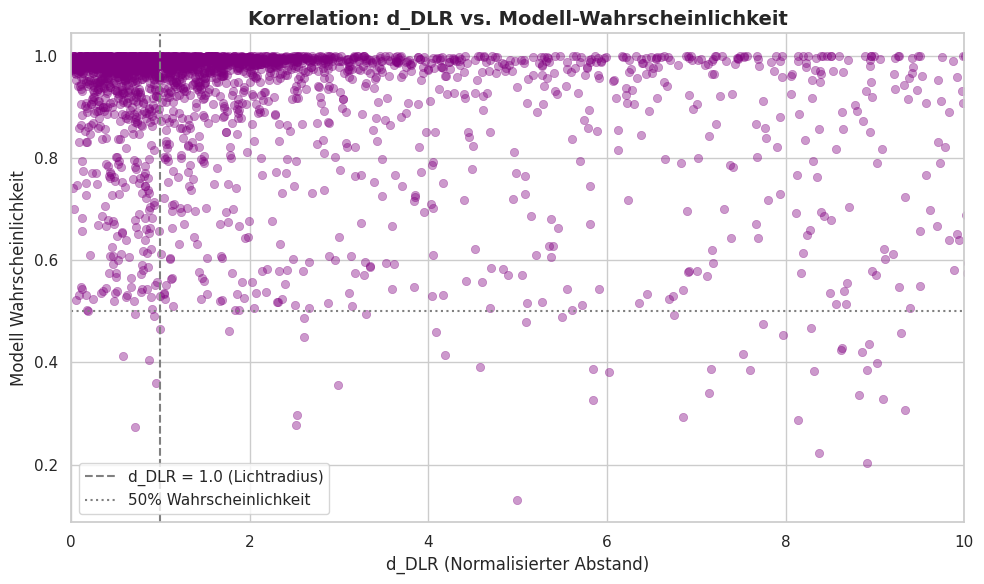

In [10]:
plt.figure(figsize=(10, 6))

# Scatterplot (nur eine Teilmenge plotten, falls es zu viele Punkte sind, z.B. 5000)
subset = rank1.sample(n=min(5000, len(rank1)), random_state=42)

sns.scatterplot(data=subset, x='d_DLR', y='normalized_prob', alpha=0.4, color='purple', edgecolor=None)

plt.title('Korrelation: d_DLR vs. Modell-Wahrscheinlichkeit', fontsize=14, fontweight='bold')
plt.xlabel('d_DLR (Normalisierter Abstand)', fontsize=12)
plt.ylabel('Modell Wahrscheinlichkeit', fontsize=12)

# Hilfslinien
plt.axvline(1.0, color='gray', linestyle='--', label='d_DLR = 1.0 (Lichtradius)')
plt.axhline(0.5, color='gray', linestyle=':', label='50% Wahrscheinlichkeit')

plt.xlim(0, 10) # Fokus auf den relevanten Bereich
plt.legend()
plt.tight_layout()
plt.show()